In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter
import time
import timeit
from Prep_dataset1 import Preprocessing_1
from metrics import confusion_matrix, plot_confusion_matrix, EXACTITUDE, PRECISION, RAPPEL, F1_score,SPECIFICITE

In [2]:
dataset = Preprocessing_1()
dataset.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Fertility
0,0.350133,0.046683,0.354422,0.640000,0.611765,0.025105,0.173254,0.004054,0.002284,0.232082,0.278407,0.018116,0.0
1,0.549072,0.037674,0.211104,0.655610,0.764706,0.040167,0.227464,0.005485,0.014844,0.494881,0.089997,0.193269,0.0
2,0.416446,0.054873,0.456423,0.652683,0.482353,0.042259,0.449934,0.005485,0.014844,0.505119,0.083846,0.193269,0.0
3,0.400531,0.031941,0.299548,0.657561,0.564706,0.035146,0.227464,0.006439,0.007536,0.491468,0.082227,0.193269,0.0
4,0.700265,0.057330,0.279535,0.656585,0.352941,0.031799,0.367589,0.004293,0.012560,0.546075,0.075105,0.193269,1.0


In [3]:
# Fournir une description globale du dataset.
def Description(dataset):
    print("Description du dataset :")
    print(dataset.describe())
    print("Description de chaque attribut du dataset :")
    print(dataset.info())
    print("Nombre de valeurs manquantes :")
    print(dataset.isnull().sum())
    print("Nombre de valeurs dupliquées :")
    print(dataset.duplicated().sum())
    print("Nombre de valeurs uniques :")
    print(dataset.nunique())
    print("Valeurs uniques de chaque attribut :")
    for col in dataset.columns:
        print(col, dataset[col].unique())
    print("Valeurs manquantes :")
    print(dataset.isna().sum())
   
 

Desccription_table = pd.DataFrame({
    'Description' : [  'Number of rows','Number of columns' ,
     'Nombre de valeurs manquantes', 'Nombre de valeurs dupliquées', 'Nombre de valeurs uniques',
      'Data types'  , 'Valeurs uniques de chaque attribut'],
    'Valeurs' : [ dataset.shape[0],dataset.shape[1] ,
     dataset.isnull().sum().tolist(), dataset.duplicated().sum(),  dataset.nunique().sum(), 
      dataset.dtypes.tolist() , dataset.isna().sum().tolist()]

})
Desccription_table

,Description,Valeurs
0,Number of rows,882
1,Number of columns,13
2,Nombre de valeurs manquantes,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Nombre de valeurs dupliquées,0
4,Nombre de valeurs uniques,1643
5,Data types,"[float64, float64, float64, float64, float64, ..."
6,Valeurs uniques de chaque attribut,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [4]:
# Fournir une description de chaque attribut du dataset.
Description_measures = {'Measures' :[ 'Number of rows','Number of columns' , 'Data types'  , 'Valeurs uniques de chaque attribut' ,
    'Number of duplicates' , 'Number of missing values' , ]}

for col in dataset.columns[0:]:
    Description_measures[col]=[
    dataset.shape[0], 
    dataset.shape[1],
    dataset.dtypes[col],
    dataset[col].nunique() , 
    dataset[col].duplicated().sum() ,
    dataset[col].isnull().sum(),
    ]
Description_measures = pd.DataFrame(Description_measures)
Description_measures

,Measures,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Fertility
0,Number of rows,882,882,882,882,882,882,882,882,882,882,882,882,882
1,Number of columns,13,13,13,13,13,13,13,13,13,13,13,13,13
2,Data types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3,Valeurs uniques de chaque attribut,56,58,58,92,71,69,126,63,386,167,424,70,3
4,Number of duplicates,826,824,824,790,811,813,756,819,496,715,458,812,879
5,Number of missing values,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
dataset.drop_duplicates(inplace=True) # Drop duplicate rows inplace (in the same DataFrame)

# Drop duplicate columns (Elimination des redondances verticales)
dataset = dataset.T.drop_duplicates().T # Transpose, drop duplicates, transpose back
# dataset = dataset.loc[:,~dataset.columns.duplicated()] # Alternative method to drop duplicate columns

dataset.shape

(882, 13)

<h2>Séparer le dataset 80% Apprentissage  20% Test</h2>

In [6]:
def custom_train_test_split(dataset, test_size=0.2, random_state=None):
    '''
    Splits a dataset into training and test sets.
    parametres:
    -----------
    
    dataset: The dataset to be split
    test_size: The proportion of the dataset to be included in the test set
    random_state: Random state for reproducibility
    returns:
    -------
    train_set: The training set
    test_set: The test set
    '''
    np.random.seed(random_state)  # Pour la reproductibilité du mélange
    
    # nombre de classes dans le dataset
    num_classes = len(np.unique(dataset[:, -1]))
    train_set = np.empty((0, dataset.shape[1]))
    test_set = np.empty((0, dataset.shape[1]))

    for i in range(0, num_classes):
        indices_classe = np.where(dataset[:, -1] == i)[0]
        np.random.shuffle(indices_classe)
        
        nb_test_samples = int(test_size * len(indices_classe))
        test_indices = indices_classe[:nb_test_samples]
        train_indices = indices_classe[nb_test_samples:]
        
        train_set = np.vstack((train_set, dataset[train_indices, :]))
        test_set = np.vstack((test_set, dataset[test_indices, :]))

    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set

In [7]:
train_set , test_set = custom_train_test_split(dataset.values, test_size=0.2, random_state=0)

print('Train set shape:', train_set.shape)
print('Test set shape:', test_set.shape)

train_set = pd.DataFrame(train_set, columns=dataset.columns)
test_set = pd.DataFrame(test_set, columns=dataset.columns)

train_set.head()

Train set shape: (706, 13)
Test set shape: (176, 13)


,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Fertility
0,0.899204,0.057330,0.320207,0.682927,0.458824,0.028452,0.257246,0.012402,0.167390,0.095563,0.460343,0.101449,1.0
1,0.501326,0.044226,0.299548,0.653659,0.376471,0.002092,0.351120,0.005247,0.076501,0.156997,0.276789,0.039855,0.0
2,0.899204,0.031941,0.313105,0.663415,0.552941,0.032636,0.296772,0.005247,0.139073,0.484642,0.298155,0.101449,1.0
3,0.639251,0.042588,0.374435,0.627317,0.388235,0.028452,0.440053,0.009301,0.003197,0.563140,0.073487,0.193269,0.0
4,0.848806,0.058968,0.511298,0.634146,0.505882,0.019665,0.176548,0.007155,0.017584,0.095563,0.042732,0.193269,1.0


In [8]:
# Transforming the train and test sets into lists
x_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1]
x_test = test_set.iloc[:, :-1]
y_test = test_set.iloc[:, -1]

x_train.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B
0,0.899204,0.057330,0.320207,0.682927,0.458824,0.028452,0.257246,0.012402,0.167390,0.095563,0.460343,0.101449
1,0.501326,0.044226,0.299548,0.653659,0.376471,0.002092,0.351120,0.005247,0.076501,0.156997,0.276789,0.039855
2,0.899204,0.031941,0.313105,0.663415,0.552941,0.032636,0.296772,0.005247,0.139073,0.484642,0.298155,0.101449
3,0.639251,0.042588,0.374435,0.627317,0.388235,0.028452,0.440053,0.009301,0.003197,0.563140,0.073487,0.193269
4,0.848806,0.058968,0.511298,0.634146,0.505882,0.019665,0.176548,0.007155,0.017584,0.095563,0.042732,0.193269


<h2>KNN</h2>

In [9]:
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

def manhattan_distance(x1, x2):
    distance = np.sum(np.abs(x1-x2))
    return distance

def cosine_distance(x1, x2):
    distance = 1 - np.dot(x1, x2) / (np.sqrt(np.dot(x1, x1)) * np.sqrt(np.dot(x2, x2)))
    return distance

In [10]:
class Knn:
    def __init__(self, k=3, distance_function = None):
        self.k = k
        self.distance_function = distance_function

    def _sort(self, distances, k):
        sorted_indices = np.argsort(distances)[:k]
        return sorted_indices

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # compute the distance
        distances = [self.distance_function(x, x_train) for x_train in self.X_train]
    
        # get the closest k
        k_indices = self._sort(distances, self.k)
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority class
        most_common = Counter(k_nearest_labels).most_common(1) 
        return most_common[0][0]

c:\Users\rachi\Bureau\Master\Tps\Projet_DM\metrics.py:85: RuntimeWarning: invalid value encountered in divide
  prec = np.diag(conf_mat) / np.sum(conf_mat, axis=0)


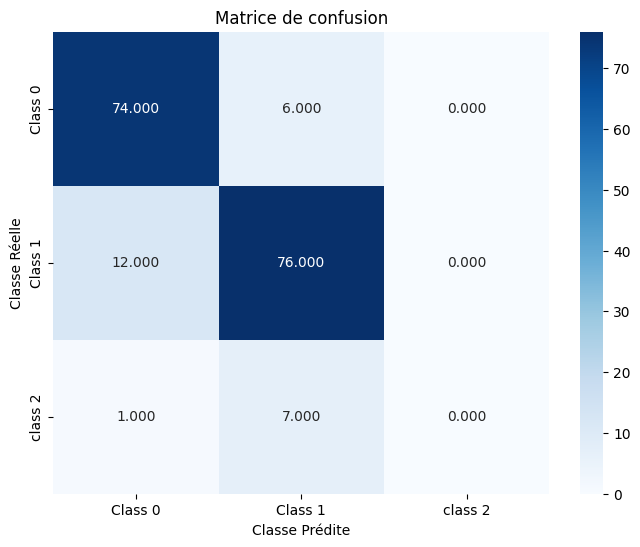

In [11]:
# Create an instance of the Knn class
knn_classifier = Knn(k=9, distance_function=euclidean_distance)

# Fit the model on the training set
knn_classifier.fit(np.array(x_train),np.array(y_train))

knn_start = time.time()
# Predict on the test set
y_pred = knn_classifier.predict(np.array(x_test))
knn_end = time.time()
Knn_time = knn_end - knn_start

#y_test = y_test.tolist()
y_pred = [int(i) for i in y_pred]
y_test = [int(i) for i in y_test]

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, len(np.unique(y_test)))
fig = plot_confusion_matrix(conf_mat, classes=['Class 0', 'Class 1','class 2'])
knn_accuracy = EXACTITUDE(conf_mat)
knn_specificity = SPECIFICITE(conf_mat)
prec , knn_precision = PRECISION(conf_mat)
rec , knn_recall = RAPPEL(conf_mat)
knn_f1_score = F1_score(conf_mat)

<h2>Decision Tree</h2>

In [12]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # Ensure that feature index is within a valid range
        if best_feature < X.shape[1]:
            left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
            right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
            return Node(best_feature, best_thresh, left, right)
        else:
            print("Invalid feature index. Skipping node creation.")
            return Node(value=self._most_common_label(y))

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            # Ensure the feature index is valid
            while feat_idx >= X.shape[1]:
                feat_idx = np.random.choice(X.shape[1], 1)[0]

            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _most_common_label(self, value):
        if isinstance(value, (int, np.int64, float, np.float64)):
            return value
        counter = Counter(value)
        most_common_value = counter.most_common(1)[0][0]
        return most_common_value

    def _traverse_tree(self, x, node):
        if node is None:
            return None

        # Ensure the feature index is valid
        while node.feature is not None and node.feature >= len(x):
            node.feature = np.random.choice(len(x), 1)[0]

        if node.feature is None or x[node.feature] is None:
            return self._most_common_label(node.value)  # Fix: use node.value instead of y

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
        
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

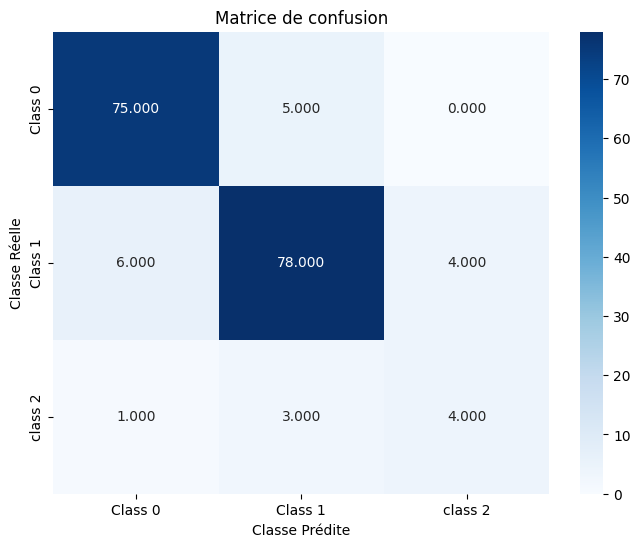

In [13]:
# Create an instance of the Decision_Tree class
decision_tree = DecisionTree(min_samples_split=10, max_depth=10, n_features=None)

# Fit the model on the training set
decision_tree.fit(np.array(x_train), np.array(y_train))

# Predict on the test set
decision_tree_start = time.time()
y_pred_dt = decision_tree.predict(np.array(x_test))
decision_tree_end = time.time()
Decision_Tree_time = decision_tree_end - decision_tree_start

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_dt, len(np.unique(y_test)))
fig = plot_confusion_matrix(conf_mat, classes=['Class 0', 'Class 1','class 2'])

# Compute the metrics
dt_accuracy = EXACTITUDE(conf_mat)
dt_specificity = SPECIFICITE(conf_mat)
prec, dt_precision = PRECISION(conf_mat)
rec, dt_recall = RAPPEL(conf_mat)
dt_f1_score = F1_score(conf_mat)

<h2>Random Forest</h2>

In [14]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=150, n_features=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        '''permet de créer un échantillon bootstrap à partir de l'ensemble de données X et y''' 
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs] 
    
    def most_common_label(self, y):
        counter = Counter(y)
        most_common_label = counter.most_common(1)[0][0]
        return most_common_label

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1) # (n_samples, n_trees) -> (n_trees, n_samples)
        y_pred = [self.most_common_label(tree_pred) for tree_pred in tree_preds]
        return y_pred

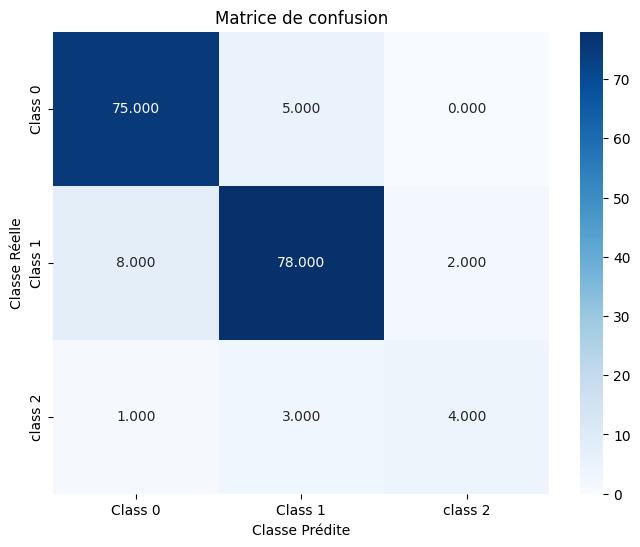

In [15]:
# Create an instance of the RandomForest class
random_forest = RandomForest(n_trees=5, min_samples_split=2, max_depth=100, n_features=None)

# Fit the model on the training set
random_forest.fit(np.array(x_train), np.array(y_train))

# Predict on the test set
random_forest_start = time.time()
y_pred_rf = random_forest.predict(np.array(x_test))
random_forest_end = time.time()
Random_Forest_time = random_forest_end - random_forest_start
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_rf, len(np.unique(y_test)))
fig = plot_confusion_matrix(conf_mat, classes=['Class 0', 'Class 1','class 2'])

# Compute the metrics
rf_accuracy = EXACTITUDE(conf_mat)
rf_specificity = SPECIFICITE(conf_mat)
prec, rf_precision = PRECISION(conf_mat)
rec, rf_recall = RAPPEL(conf_mat)
rf_f1_score = F1_score(conf_mat)

<h2>temps moyen d'execution </h2>

In [16]:
execution_times =[]
models = [knn_classifier, decision_tree, random_forest]
number_of_execution = 50
for model in models:
    execution_time =timeit.timeit(lambda: model.predict(np.array(x_test)), number=number_of_execution)
    execution_times.append({'model' : str(model), 'execution_time' : execution_time})

In [17]:
#on devise execution time par le nombre d'execution pour avoir le temps d'execution moyen
execution_times = pd.DataFrame(execution_times)
execution_times['execution_time'] = execution_times['execution_time'] / number_of_execution
#mettre a jour les noms des models dans la colonne model

In [18]:
model=['Knn', 'Decision Tree', 'Random Forest']
#modify model column name
execution_times['model'] = model 
execution_times

,model,execution_time
0,Knn,0.785700
1,Decision Tree,0.000468
2,Random Forest,0.005010


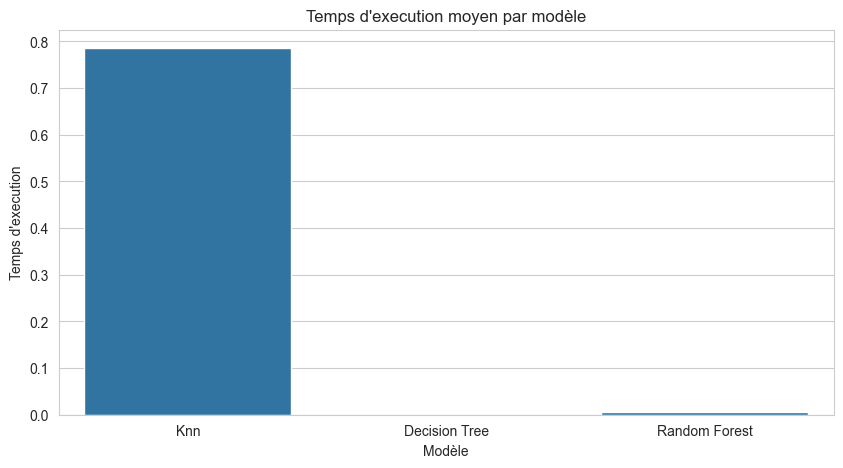

In [19]:
#plot execution time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
plt.title('Temps d\'execution moyen par modèle')
plt.xlabel('Modèle')
plt.ylabel('Temps d\'execution')
sns.barplot(x='model', y='execution_time', data=execution_times)
plt.show()

Illustration par des exemples

In [20]:
# # affecting instance the first value of x_test  
# instance = x_test.iloc[0].values
# print('instance :',instance)

In [21]:
# #knn sur l'instance
# knn = Knn(k=9, distance_function=euclidean_distance)

# # Fit the model on the training set
# knn.fit(np.array(x_train),np.array(y_train))

# # Predict on the test set
# y_pred_instance = knn.predict([list(instance)])
# print('la classe predite est : ',y_pred_instance)

In [22]:
# dt = DecisionTree(min_samples_split=10, max_depth=10, n_features=None)

# # Fit the model on the training set
# dt.fit(np.array(x_train), np.array(y_train))

# # Predict on the test set
# y_pred_dt = dt.predict([list(instance)])
# print('la classe predite est :', y_pred_dt)

In [23]:
# random_forest = RandomForest(n_trees=10, min_samples_split=10, max_depth=20, n_features=None)

# # Fit the model on the training set
# random_forest.fit(np.array(x_train), np.array(y_train))

# # Predict on the test set
# y_pred_rf = random_forest.predict([list(instance)])
# print('la classe predite est :', y_pred_rf)

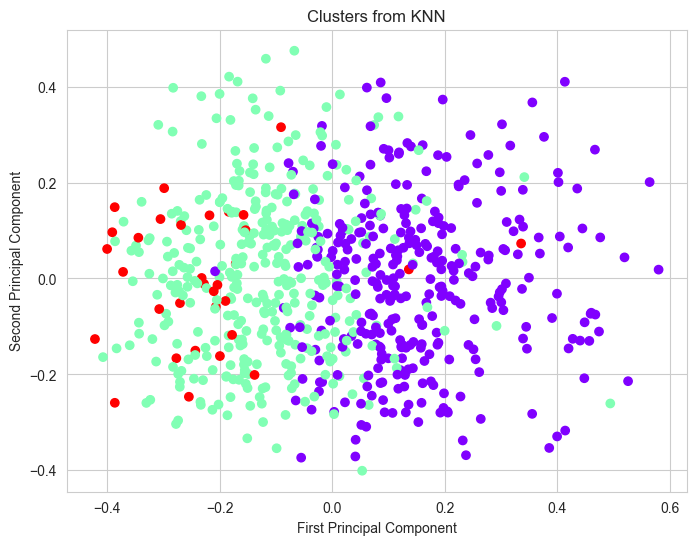

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
x_pca = pca.transform(x_train)

#plotting the clusters
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_train,cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters from KNN')
plt.show()

<h1>Les Metrics</h1>

In [25]:
# dataframe to compare the metrics of the three models
metrics = {'Metrics': ['Accuracy', 'Specificity', 'Precision', 'Recall', 'F1 score' , 'Time'],
           'Knn': [knn_accuracy, knn_specificity, knn_precision, knn_recall, knn_f1_score , execution_times['execution_time'][0]],
           'Decision Tree': [dt_accuracy, dt_specificity, dt_precision, dt_recall, dt_f1_score , execution_times['execution_time'][1]],
           'Random Forest': [rf_accuracy, rf_specificity, rf_precision, rf_recall, rf_f1_score , execution_times['execution_time'][2]]}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metrics,Knn,Decision Tree,Random Forest
0,Accuracy,0.852273,0.892045,0.892045
1,Specificity,0.596212,0.774621,0.774621
2,Precision,0.852254,0.773870,0.822167
3,Recall,0.596212,0.774621,0.774621
4,F1 score,0.872492,0.774159,0.794205
5,Time,0.785700,0.000468,0.005010


<h1> BONUS </h1>

c:\Users\rachi\Bureau\Master\Tps\Projet_DM\metrics.py:85: RuntimeWarning: invalid value encountered in divide
  prec = np.diag(conf_mat) / np.sum(conf_mat, axis=0)


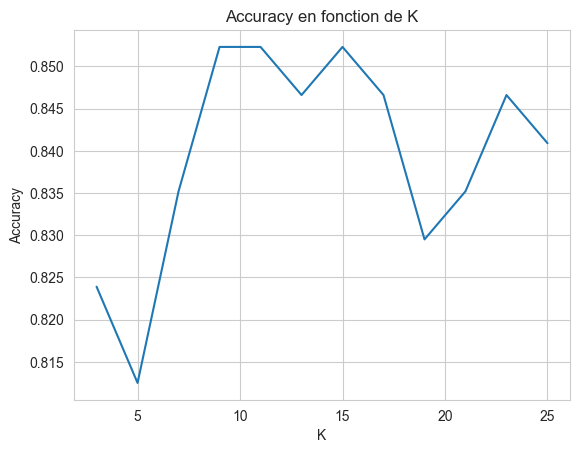

In [26]:
def exprimentation_knn():
    'return accuracy , specificity , precision , recall , f1_score et le k pour chaque k '
    k = [3,5,7,9,11,13,15,17,19,21,23,25]
    accuracy = []
    specificity = []
    precision = []
    recall = []
    f1_score = []

    for i in k:
        knn_classifier = Knn(k=i, distance_function=euclidean_distance)
        knn_classifier.fit(np.array(x_train),np.array(y_train))
        y_pred = knn_classifier.predict(np.array(x_test))
        y_pred = [int(i) for i in y_pred]
        conf_mat = confusion_matrix(y_test, y_pred, len(np.unique(y_test)))
        accuracy.append(round(EXACTITUDE(conf_mat),4))
        specificity.append(round(SPECIFICITE(conf_mat),4))
        prec , precision_mean = PRECISION(conf_mat)
        precision.append(round(precision_mean,4))
        rec , recall_mean = RAPPEL(conf_mat)
        recall.append(round(recall_mean,4))
        f1_score.append(round(F1_score(conf_mat),4))
    return k , accuracy , specificity , precision , recall , f1_score



k, accuracy , specificity , precision , recall , f1_score = exprimentation_knn()

#plot accuracy en fonction de k

import matplotlib.pyplot as plt
plt.plot(k,accuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de K')
plt.show()

In [27]:
df = pd.DataFrame({'k':k , 'accuracy':accuracy , 'specificity':specificity , 'precision':precision , 'recall':recall , 'f1_score':f1_score})
df

,k,accuracy,specificity,precision,recall,f1_score
0,3,0.8239,0.6133,0.7189,0.6133,0.6284
1,5,0.8125,0.5686,0.8125,0.5686,0.8317
2,7,0.8352,0.5848,0.8355,0.5848,0.8548
3,9,0.8523,0.5962,0.8523,0.5962,0.8725
4,11,0.8523,0.5958,0.8525,0.5958,0.8726
5,13,0.8466,0.5920,0.8466,0.5920,0.8667
6,15,0.8523,0.5958,0.8525,0.5958,0.8726
7,17,0.8466,0.5920,0.8466,0.5920,0.8667
8,19,0.8295,0.5799,0.8297,0.5799,0.8493
9,21,0.8352,0.5841,0.8353,0.5841,0.8551


In [28]:
def exprimentation_dt():
    max_depth = [20,100, 150, 200]
    min_samples_split = [2, 5, 10,20]

    accuracy = []
    specificity = []
    precision = []
    recall = []
    f1_score = []
    max_depth_list = []
    min_samples_split_list = []

    for i in max_depth:
        for j in min_samples_split:
            decision_tree = DecisionTree(min_samples_split=j, max_depth=i, n_features=None)
            decision_tree.fit(np.array(x_train), np.array(y_train))
            y_pred_dt = decision_tree.predict(np.array(x_test))
            conf_mat = confusion_matrix(y_test, y_pred_dt, len(np.unique(y_test)))
            accuracy.append(round(EXACTITUDE(conf_mat), 4))
            specificity.append(round(SPECIFICITE(conf_mat), 4))
            prec, precision_mean = PRECISION(conf_mat)
            precision.append(round(precision_mean, 4))
            rec, recall_mean = RAPPEL(conf_mat)
            recall.append(round(recall_mean, 4))
            f1_score.append(round(F1_score(conf_mat), 4))
            max_depth_list.append(i)
            min_samples_split_list.append(j)

    df = pd.DataFrame({'max_depth': max_depth_list, 'min_samples_split': min_samples_split_list, 'accuracy': accuracy,
                   'specificity': specificity, 'precision': precision, 'recall': recall, 'f1_score': f1_score})

    return df

exprimentation_dt()

,max_depth,min_samples_split,accuracy,specificity,precision,recall,f1_score
0,20,2,0.8807,0.7284,0.7634,0.7284,0.7429
1,20,5,0.8750,0.7629,0.7619,0.7629,0.7622
2,20,10,0.8920,0.7367,0.7708,0.7367,0.7507
3,20,20,0.8920,0.7746,0.7739,0.7746,0.7742
4,100,2,0.8807,0.7667,0.7659,0.7667,0.7662
5,100,5,0.8693,0.7591,0.7317,0.7591,0.7432
6,100,10,0.8864,0.7708,0.7698,0.7708,0.7701
7,100,20,0.8920,0.7367,0.7708,0.7367,0.7507
8,150,2,0.8750,0.7250,0.7387,0.7250,0.7312
9,150,5,0.8750,0.7254,0.7242,0.7254,0.7245


In [29]:
def exprimentation_RF():
    ''' return accuracy , specificity , precision , recall , f1_score , max_depth , min_samples_split , n_trees '''
    max_depth = [100, 150]
    min_samples_split = [2, 5, 10]
    n_trees = [5,10,20]

    accuracy = []
    specificity = []
    precision = []
    recall = []
    f1_score = []
    max_depth_list = []
    min_samples_split_list = []
    n_trees_list = []

    for i in max_depth:
        for j in min_samples_split:
            for k in n_trees:
                random_forest = RandomForest(n_trees=k, min_samples_split=j, max_depth=i, n_features=None)
                random_forest.fit(np.array(x_train), np.array(y_train))
                y_pred_rf = random_forest.predict(np.array(x_test))
                conf_mat = confusion_matrix(y_test, y_pred_rf, len(np.unique(y_test)))
                accuracy.append(round(EXACTITUDE(conf_mat), 4))
                specificity.append(round(SPECIFICITE(conf_mat), 4))
                prec, precision_mean = PRECISION(conf_mat)
                precision.append(round(precision_mean, 4))
                rec, recall_mean = RAPPEL(conf_mat)
                recall.append(round(recall_mean, 4))
                f1_score.append(round(F1_score(conf_mat), 4))
                max_depth_list.append(i)
                min_samples_split_list.append(j)
                n_trees_list.append(k)

    df = pd.DataFrame({'max_depth': max_depth_list, 'min_samples_split': min_samples_split_list, 'n_trees': n_trees_list,
                     'accuracy': accuracy, 'specificity': specificity, 'precision': precision, 'recall': recall,
                     'f1_score': f1_score})
    
    return df

exprimentation_RF()

,max_depth,min_samples_split,n_trees,accuracy,specificity,precision,recall,f1_score
0,100,2,5,0.9148,0.7902,0.8380,0.7902,0.8101
1,100,2,10,0.8920,0.7364,0.8471,0.7364,0.7708
2,100,2,20,0.8864,0.7326,0.7967,0.7326,0.7559
3,100,5,5,0.8920,0.6989,0.7383,0.6989,0.7127
4,100,5,10,0.8977,0.7409,0.8507,0.7409,0.7747
5,100,5,20,0.8750,0.7246,0.8353,0.7246,0.7590
6,100,10,5,0.8920,0.7364,0.7713,0.7364,0.7508
7,100,10,10,0.8807,0.7292,0.7627,0.7292,0.7428
8,100,10,20,0.9034,0.7068,0.8274,0.7068,0.7354
9,150,2,5,0.8807,0.7667,0.8143,0.7667,0.7863
